# Loading Libraries and Initialize

In [2]:
%%capture
%run -i 1-ReadingData.ipynb

# Autoregressive–moving-average model

\begin{align}
& \ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})& \mbox{level} \\
& b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} & \mbox{trend} \\
& s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L} & \mbox{seasonal} \\
& \hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}& \mbox{forecast}\\
\end{align}
- α is smoothing parameter where 0≤ α ≤1.
- β coefficient is a weight in the exponential smoothing where 0≤ β ≤1.
- γ is the smoothing factor for the seasonal component where 0≤ γ ≤1.
- TES is useful to understand the trend and intercept with seasonality.

https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm

https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3


## Initial Trend
For double exponential smoothing we simply used the first two points for the initial trend. With seasonal data we can do better than that, since we can observe many seasons and can extrapolate a better starting trend. The most common practice is to compute the average of trend averages across seasons.

In [3]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

## Initial Seasonal Components
The situation is even more complicated when it comes to initial values for the seasonal components. Briefly, we need to compute the average level for every observed season we have, divide every observed value by the average for the season it’s in and finally average each of these numbers across our observed seasons. 

In [4]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

## The Algorithm

In [5]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
        
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon    
    """
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

# Calculating Triple Exponential Smoothing

In [6]:
season_len = 300
alpha, beta, gamma = 0.9, 0.9, 0.9
df['tes1'] = triple_exponential_smoothing(df['close'], season_len, alpha, beta, gamma, 0)
alpha, beta, gamma = 0.9, 0.02, 0.9
df['tes2'] = triple_exponential_smoothing(df['close'], season_len, alpha, beta, gamma, 0)
alpha, beta, gamma = 0.9, 0.9, 0.02
df['tes3'] = triple_exponential_smoothing(df['close'], season_len, alpha, beta, gamma, 0)
alpha, beta, gamma = 0.02, 0.9, 0.9
df['tes4'] = triple_exponential_smoothing(df['close'], season_len, alpha, beta, gamma, 0)
alpha, beta, gamma = 0.02, 0.02, 0.9
df['tes5'] = triple_exponential_smoothing(df['close'], season_len, alpha, beta, gamma, 0)
alpha, beta, gamma = 0.9, 0.02, 0.02
df['tes6'] = triple_exponential_smoothing(df['close'], season_len, alpha, beta, gamma, 0)
alpha, beta, gamma = 0.02, 0.9, 0.02
df['tes7'] = triple_exponential_smoothing(df['close'], season_len, alpha, beta, gamma, 0)
alpha, beta, gamma = 0.02, 0.02, 0.02
df['tes8'] = triple_exponential_smoothing(df['close'], season_len, alpha, beta, gamma, 0)
df.tail(10)

,open,high,low,close,volume,Name,tes1,tes2,tes3,tes4,tes5,tes6,tes7,tes8
date,,,,,,,,,,,,,,
2018-01-25,174.505,174.9500,170.5300,171.11,41529004,AAPL,167.503818,171.450076,167.645415,226.025836,168.766093,171.837328,168.099902,165.864457
2018-01-26,172.000,172.0000,170.0600,171.51,39143011,AAPL,170.690137,171.801306,170.430775,234.441333,169.255109,171.849148,170.832435,166.539172
2018-01-29,170.160,170.1600,167.0700,167.96,50640406,AAPL,164.264546,168.203368,164.563853,237.979577,166.346743,168.658771,174.300148,168.079716
2018-01-30,165.525,167.3700,164.7000,166.97,46048185,AAPL,164.722374,167.143091,164.456892,241.983580,165.473843,167.348252,176.946926,168.993548
2018-01-31,166.870,168.4417,166.5000,167.43,32478930,AAPL,166.503406,167.572243,166.423601,245.620650,165.919234,167.660866,179.818107,170.367557
2018-02-01,167.165,168.6200,166.7600,167.78,47230787,AAPL,167.194828,167.904841,167.237376,247.477896,166.398599,167.978377,182.264873,171.588799
2018-02-02,166.000,166.8000,160.1000,160.50,86593825,AAPL,154.284428,160.552217,154.834892,240.309307,159.843148,161.254481,183.522254,172.048433
2018-02-05,159.100,163.8800,156.0000,156.49,72738522,AAPL,152.187098,156.431975,151.979210,234.040044,156.139214,156.765415,182.834113,171.046358
2018-02-06,154.830,163.7200,154.0000,163.03,68243838,AAPL,167.390484,162.981399,166.440400,235.625928,162.064668,162.455550,183.352957,171.618435


# Visualizing All Data

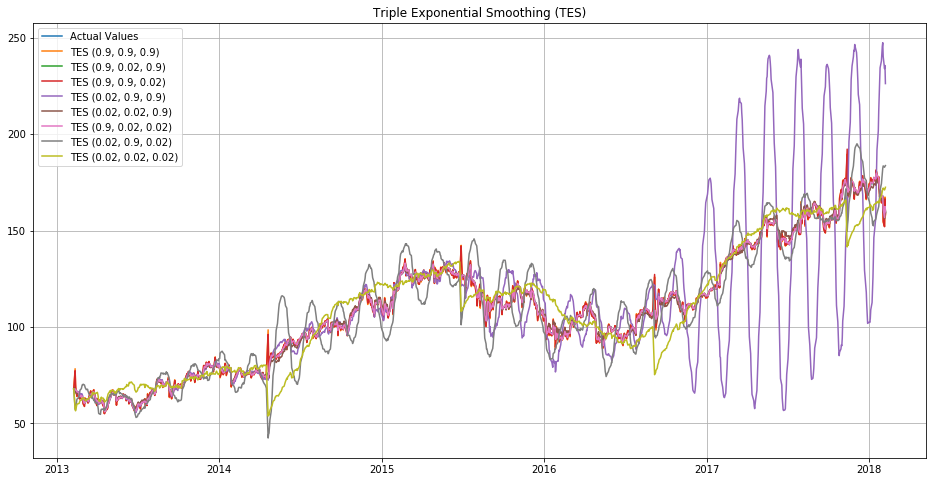

In [7]:
plt.figure(figsize=(16,8))
plt.title('Triple Exponential Smoothing (TES)')

plt.plot(df['close'], label='Actual Values')
plt.plot(df['tes1'], label='TES (0.9, 0.9, 0.9)')
plt.plot(df['tes2'], label='TES (0.9, 0.02, 0.9)')
plt.plot(df['tes3'], label='TES (0.9, 0.9, 0.02)')
plt.plot(df['tes4'], label='TES (0.02, 0.9, 0.9)')
plt.plot(df['tes5'], label='TES (0.02, 0.02, 0.9)')
plt.plot(df['tes6'], label='TES (0.9, 0.02, 0.02)')
plt.plot(df['tes7'], label='TES (0.02, 0.9, 0.02)')
plt.plot(df['tes8'], label='TES (0.02, 0.02, 0.02)')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Visualizing Last 200 Days

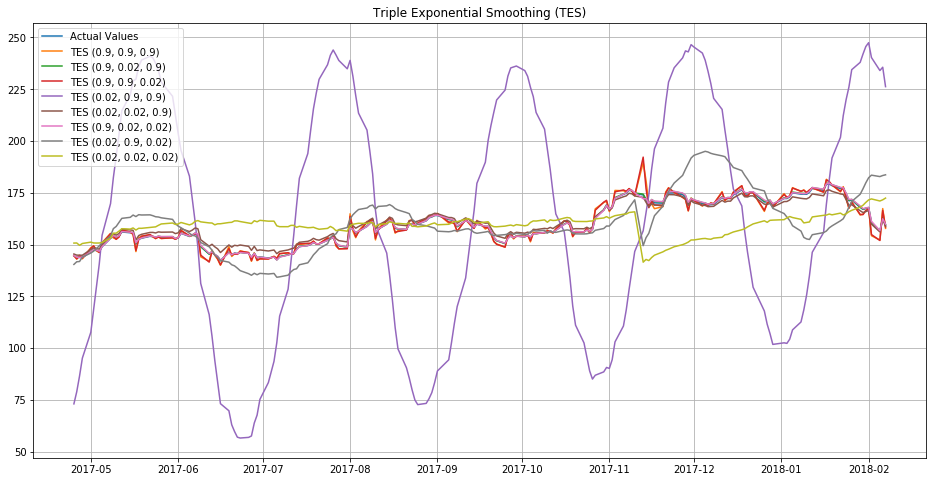

In [8]:
df1 = df[-200:]

plt.figure(figsize=(16,8))
plt.title('Triple Exponential Smoothing (TES)')

plt.plot(df1['close'], label='Actual Values')
plt.plot(df1['tes1'], label='TES (0.9, 0.9, 0.9)')
plt.plot(df1['tes2'], label='TES (0.9, 0.02, 0.9)')
plt.plot(df1['tes3'], label='TES (0.9, 0.9, 0.02)')
plt.plot(df1['tes4'], label='TES (0.02, 0.9, 0.9)')
plt.plot(df1['tes5'], label='TES (0.02, 0.02, 0.9)')
plt.plot(df1['tes6'], label='TES (0.9, 0.02, 0.02)')
plt.plot(df1['tes7'], label='TES (0.02, 0.9, 0.02)')
plt.plot(df1['tes8'], label='TES (0.02, 0.02, 0.02)')

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])